In [2]:
import pandas as pd
import pystan
import itertools
import warnings
import arviz as az
from sklearn import datasets
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
sns.set(style="white", color_codes=True)

In [83]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
species = ['setosa', 'versicolor', 'virginica']
data = pd.DataFrame(datasets.load_iris().data, columns=features)
target = datasets.load_iris().target
target_names = np.array(list(map(lambda x: species[x], target)))
data['species'] = target_names

In [84]:
def scale(X, d):
    center = np.array([np.mean(X[:,i]) for i in range(d)])
    X_centered = X - center
    X_scaled = X_centered/np.sqrt(np.var(X_centered))
    
    return X_scaled

In [85]:
X = data.loc[:, features]
X_scaled = scale(X.values, 4)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
Y = data.loc[:,['species']].values

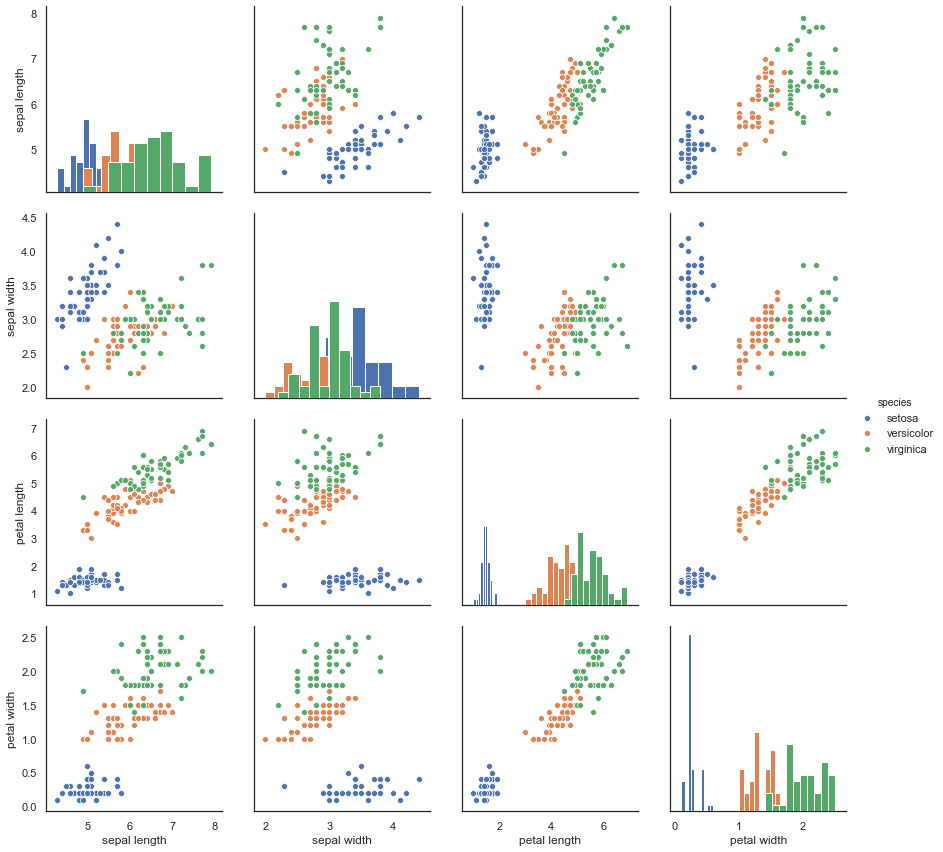

In [86]:
sns.pairplot(data, diag_kind="hist", hue="species", size=3)

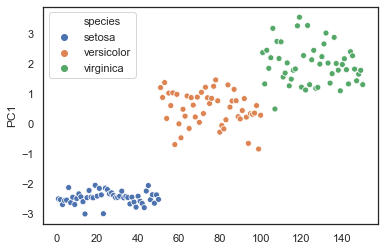

In [87]:
pca = PCA(n_components=1)
pca.fit(X_scaled)
X_pca_array = pca.transform(X_scaled)
X_pca = pd.DataFrame(X_pca_array, columns=['PC1'])
df_pca = X_pca.copy()
df_pca['species'] = Y
sns.scatterplot(x=range(1,len(df_pca)+1), y='PC1',data=df_pca, hue='species')

In [89]:
pcaacomponents_mponents_[0]

array([ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ])

In [88]:
model = """
data {
 int<lower = 0> N;
 int<lower = 1> F;
 int<lower = 1> J;
 vector[F] sign;
 vector[F] beta_prior;
 matrix[N,F] y;
}

transformed data {
    matrix[N,F] y_signed;
    vector[F] beta_prior_signed;
    
    for (i in 1:N) {
        y_signed[i] = y[i] .* sign';
    }
    
    beta_prior_signed = beta_prior .* sign;
}

parameters {
  ordered[J] mu;
  simplex[F] beta;
  simplex[J] theta;
  real<lower=0> sigma[J];
}

model {
    vector[N] y_1d;
    vector[J] log_theta;
    
    beta ~ normal(beta_prior_signed, 0.01);
    sigma ~ lognormal(0, 1);
    mu ~ normal(0, 10);
    theta ~ normal(0.33, 0.01);
    log_theta = log(theta);  // cache log calculation
    y_1d = y_signed * beta;
    
    for (n in 1:N) {
        vector[J] lps = log_theta;
        for (j in 1:J)
          lps[j] += normal_lpdf(y_1d[n] | mu[j], sigma[j]);
        target += log_sum_exp(lps);
    }
}

generated quantities {
    vector[N] y_pred;
    int<lower=1, upper=J> comp[N];
    vector[N] log_lik;
    vector[N] y_1d;
    
    y_1d = y_signed * beta;
    
    for (n in 1:N) {
        vector[J] lps;
        
        for (j in 1:J) {
            lps[j] = log(theta[j]) + normal_lpdf(y_1d[n] | mu[j], sigma[j]);
        }
        
        log_lik[n] = log_sum_exp(lps);
        
        comp[n] = categorical_rng(theta);
        y_pred[n] = normal_rng(mu[comp[n]], sigma[comp[n]]);
    }
}
"""

iris_dat = {'N': len(X_scaled),
            'F': len(X_scaled.columns),
            'J': 3,
            'sign': np.sign(pca.components_[0]),
            'beta_prior': pca.components_[0],
            'y': X_scaled.values}

sm = pystan.StanModel(model_code=model)
fit_first = sm.sampling(data=iris_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f894d32b132932d829e49e246fc4920b NOW.


In [90]:
print(fit_first)

Inference for Stan model: anon_model_f894d32b132932d829e49e246fc4920b.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]          -1.71  6.0e-4    0.02  -1.76  -1.72  -1.71  -1.69  -1.66   1567    1.0
mu[2]            0.6  6.2e-3    0.15   0.34   0.48    0.6   0.72   0.87    589   1.01
mu[3]            1.1  6.3e-3    0.17   0.81   0.97    1.1   1.24   1.41    703   1.01
beta[1]         0.17  2.4e-4  8.4e-3   0.15   0.16   0.17   0.17   0.18   1264    1.0
beta[2]       1.1e-3  2.5e-5  1.1e-3 3.5e-5 3.2e-4 7.8e-4 1.5e-3 4.2e-3   1974    1.0
beta[3]         0.66  2.0e-4  8.1e-3   0.64   0.66   0.66   0.67   0.68   1698    1.0
beta[4]         0.17  2.3e-4  8.6e-3   0.15   0.17   0.17   0.18   0.19   1337    1.0
theta[1]        0.33  2.0e-4  7.9e-3   0.32   0.33   0.33   0.34   0.35   1493    1.0
theta[2]        0.33  1.8e-4  8.0e-3   

## Model Checking
### Sensitive analysis

Let's look at the marginal posterior distributions:

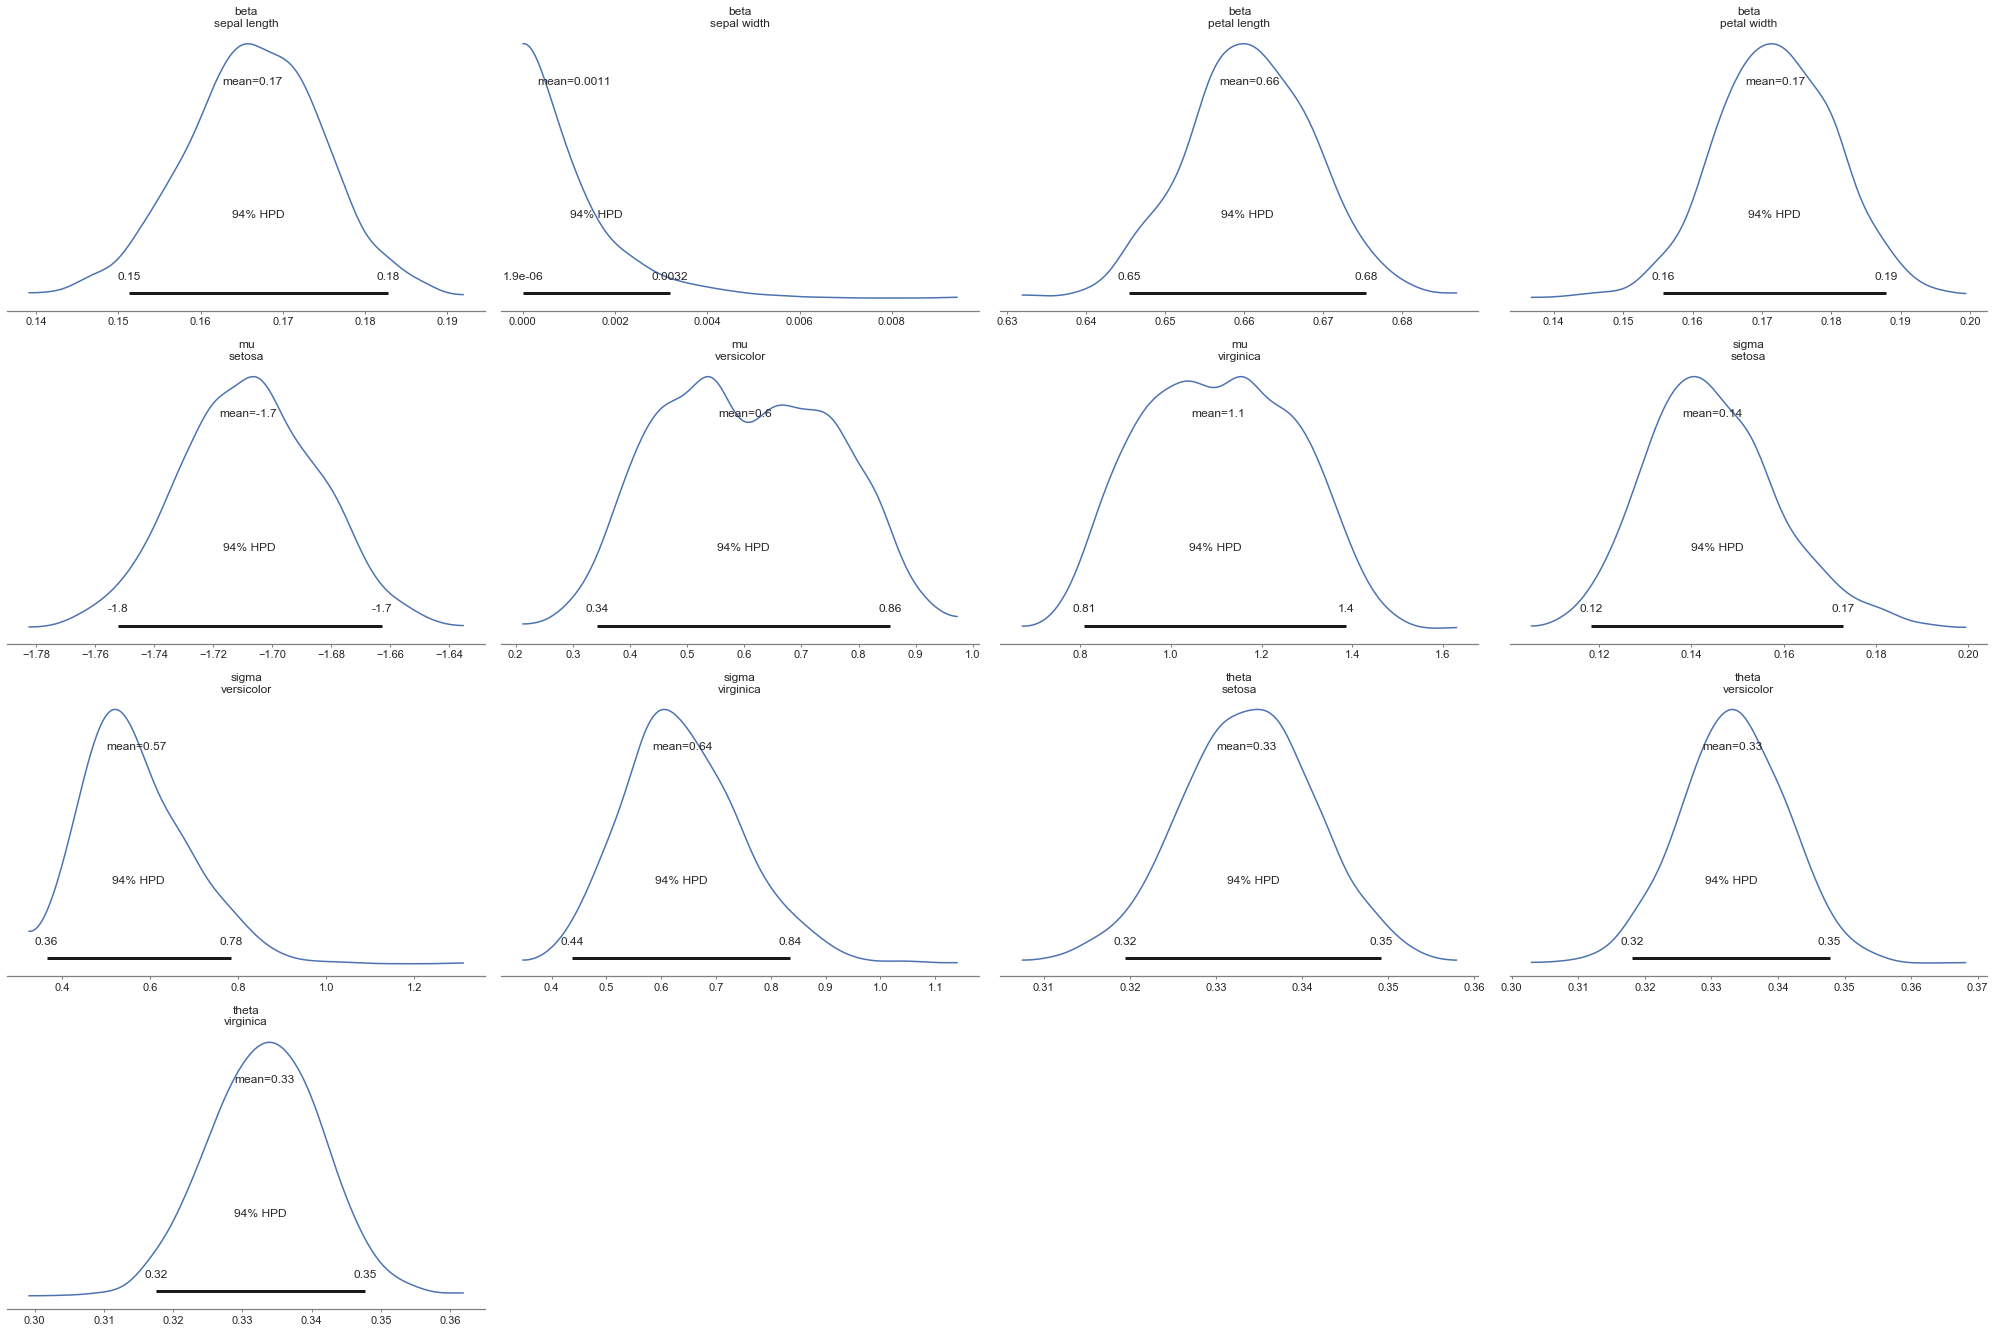

In [93]:
fit_data = az.from_pystan(
    posterior=fit_first,
    posterior_predictive=["y_pred","y_1d"],
    observed_data=["y"],
    log_likelihood={"y": "log_lik"},
    coords={"species": species, "features": features},
    dims={
        "beta": ["features"],
        "mu": ["species"],
        "sigma": ["species"],
        "theta": ["species"]
    },
)

_ = az.plot_posterior(fit_data, ['beta', 'mu', 'sigma', 'theta'])

In [94]:
max_test, min_test, mean_test, std_test, med_test = ([] for i in range(5))
max_test_rl, min_test_rl, mean_test_rl, std_test_rl, med_test_rl = ([] for i in range(5))
for unique_value, grouped_array in fit_data.posterior_predictive.sel(chain=0).groupby('draw'):
    ypred = grouped_array.y_pred.values
    y_1d = grouped_array.y_1d.values
    max_test_rl.append(np.max(y_1d))
    min_test_rl.append(np.min(y_1d))
    mean_test_rl.append(np.mean(y_1d))
    std_test_rl.append(np.std(y_1d))
    med_test_rl.append(np.median(y_1d))
    max_test.append(np.max(ypred))
    min_test.append(np.min(ypred))
    mean_test.append(np.mean(ypred))
    std_test.append(np.std(ypred))
    med_test.append(np.median(ypred))

In [48]:
def calc_p(lst, value):
    return len(list(filter(lambda x: x <= value, lst))) / len(lst)

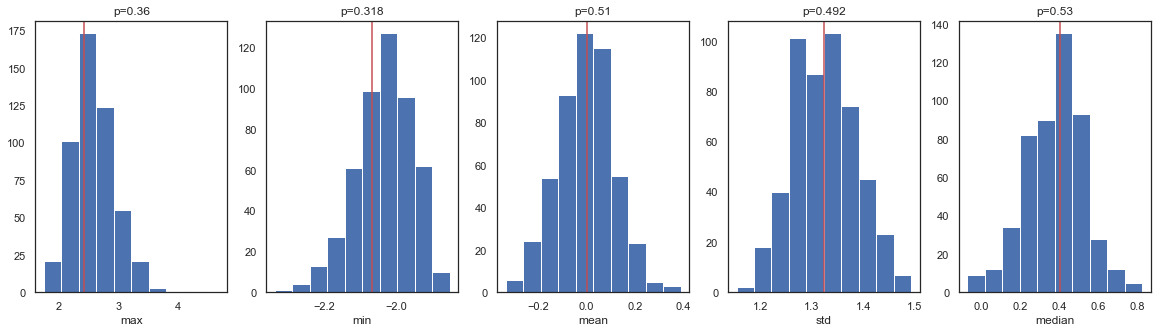

In [95]:
fig, axs = plt.subplots(1, 5, figsize=(20,5))
axs[0].hist(max_test)
axs[0].axvline(np.mean(max_test_rl), color='r')
axs[0].set_xlabel('max')
axs[0].set_title('p=' + str(calc_p(max_test, np.mean(max_test_rl))))
axs[1].hist(min_test)
axs[1].axvline(np.mean(min_test_rl), color='r')
axs[1].set_xlabel('min')
axs[1].set_title('p=' + str(calc_p(min_test, np.mean(min_test_rl))))
axs[2].hist(mean_test)
axs[2].axvline(np.mean(mean_test_rl), color='r')
axs[2].set_xlabel('mean')
axs[2].set_title('p=' + str(calc_p(mean_test, np.mean(mean_test_rl))))
axs[3].hist(std_test)
axs[3].axvline(np.mean(std_test_rl), color='r')
axs[3].set_xlabel('std')
axs[3].set_title('p=' + str(calc_p(std_test, np.mean(std_test_rl))))
axs[4].hist(med_test)
axs[4].axvline(np.mean(med_test_rl), color='r')
axs[4].set_xlabel('median')
_ = axs[4].set_title('p=' + str(calc_p(med_test, np.mean(med_test_rl))))

#### Graphical posterior predictive check

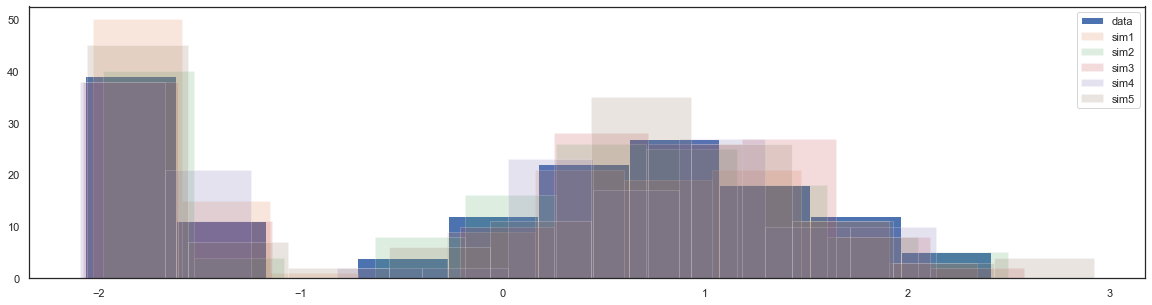

In [96]:
fig, axs = plt.subplots(1, 1, figsize=(20,5))
scaled_1d_data = X_scaled.values @ fit_first.extract()['beta'].mean(axis=0)
axs.hist(scaled_1d_data, label='data')
fit_values = fit_data.posterior_predictive.sel(chain=0).y_pred.values
for i in range(5):
    axs.hist(fit_values[i], label='sim' + str(i+1), alpha=0.2)

axs.legend()
    
plt.show()

In [97]:
fitted_mu = fit_first.extract()['mu'].mean(axis=0)
fitted_sigma = fit_first.extract()['sigma'].mean(axis=0)
N = iris_dat['N']
J = iris_dat['J']
correct = 0
for i in range(N):
    p = [0] * J
    for j in range(J):
        p[j] = stats.norm.pdf(scaled_1d_data[i], fitted_mu[j], fitted_sigma[j])
    correct += np.argmax(p) == target[i]

print('Guessing score: ' + str(round(correct/N * 100,2)) + '%')

Guessing score: 94.0%


In [72]:
model = """
data {
 int<lower = 0> N;
 int<lower = 1> F;
 int<lower = 1> J;
 vector[F] sign;
 vector[F] beta_prior;
 matrix[N,F] y;
}

transformed data {
    matrix[N,F] y_signed;
    vector[F] beta_prior_signed;
    
    for (i in 1:N) {
        y_signed[i] = y[i] .* sign';
    }
    
    beta_prior_signed = beta_prior .* sign;
}

parameters {
  ordered[J] mu;
  vector<lower=0, upper=0.025>[F] tau;
  simplex[F] beta;
  simplex[J] theta;
  real<lower=0> sigma[J];
}

model {
    vector[N] y_1d;
    vector[J] log_theta;
    tau ~ normal(0, 0.01);
    beta ~ normal(beta_prior_signed, tau);
    sigma ~ normal(1, 0.1);
    mu ~ normal(0, 10);
    theta ~ normal(0.33, 0.001);
    log_theta = log(theta);  // cache log calculation
    y_1d = y_signed * beta;
    
    for (n in 1:N) {
        vector[J] lps = log_theta;
        for (j in 1:J)
          lps[j] += normal_lpdf(y_1d[n] | mu[j], sigma[j]);
        target += log_sum_exp(lps);
    }
}

generated quantities {
    vector[N] y_pred;
    int<lower=1, upper=J> comp[N];
    vector[N] log_lik;
    vector[N] y_1d;
    vector[F] b;

    b = beta_prior_signed;
    
    y_1d = y_signed * beta;
    
    for (n in 1:N) {
        vector[J] lps;
        
        for (j in 1:J) {
            lps[j] = log(theta[j]) + normal_lpdf(y_1d[n] | mu[j], sigma[j]);
        }
        
        log_lik[n] = log_sum_exp(lps);
        
        comp[n] = categorical_rng(theta);
        y_pred[n] = normal_rng(mu[comp[n]], sigma[comp[n]]);
    }
}
"""

iris_dat = {'N': len(X_scaled),
            'F': len(X_scaled.columns),
            'J': 3,
            'sign': np.sign(pca.components_[0]),
            'beta_prior': pca.components_[0],
            'y': X_scaled.values}

sm = pystan.StanModel(model_code=model)
fit_expanded = sm.sampling(data=iris_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ac1788b7323fe0de36b447cc9c8e6bbe NOW.


In [73]:
print(fit_expanded)

Inference for Stan model: anon_model_ac1788b7323fe0de36b447cc9c8e6bbe.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean      sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
mu[1]           -1.68  1.1e-3    0.04  -1.76   -1.7  -1.68  -1.65    -1.6   1239    1.0
mu[2]            0.72  4.3e-3    0.13   0.44   0.64   0.73   0.81    0.93    842    1.0
mu[3]            0.94  2.9e-3    0.12   0.72   0.85   0.93   1.01    1.19   1681    1.0
tau[1]           0.02  8.5e-6  4.0e-4   0.02   0.02   0.02   0.02    0.02   2150    1.0
tau[2]           0.02  8.6e-5  2.8e-3   0.01   0.02   0.02   0.02    0.02   1047    1.0
tau[3]           0.02  7.9e-6  3.6e-4   0.02   0.02   0.02   0.02    0.02   2133    1.0
tau[4]           0.02  1.3e-5  5.9e-4   0.02   0.02   0.02   0.02    0.02   2135    1.0
beta[1]          0.15  5.1e-4    0.02   0.11   0.14   0.15   0.17    0.19   1698    1.0
beta[2]          0.02

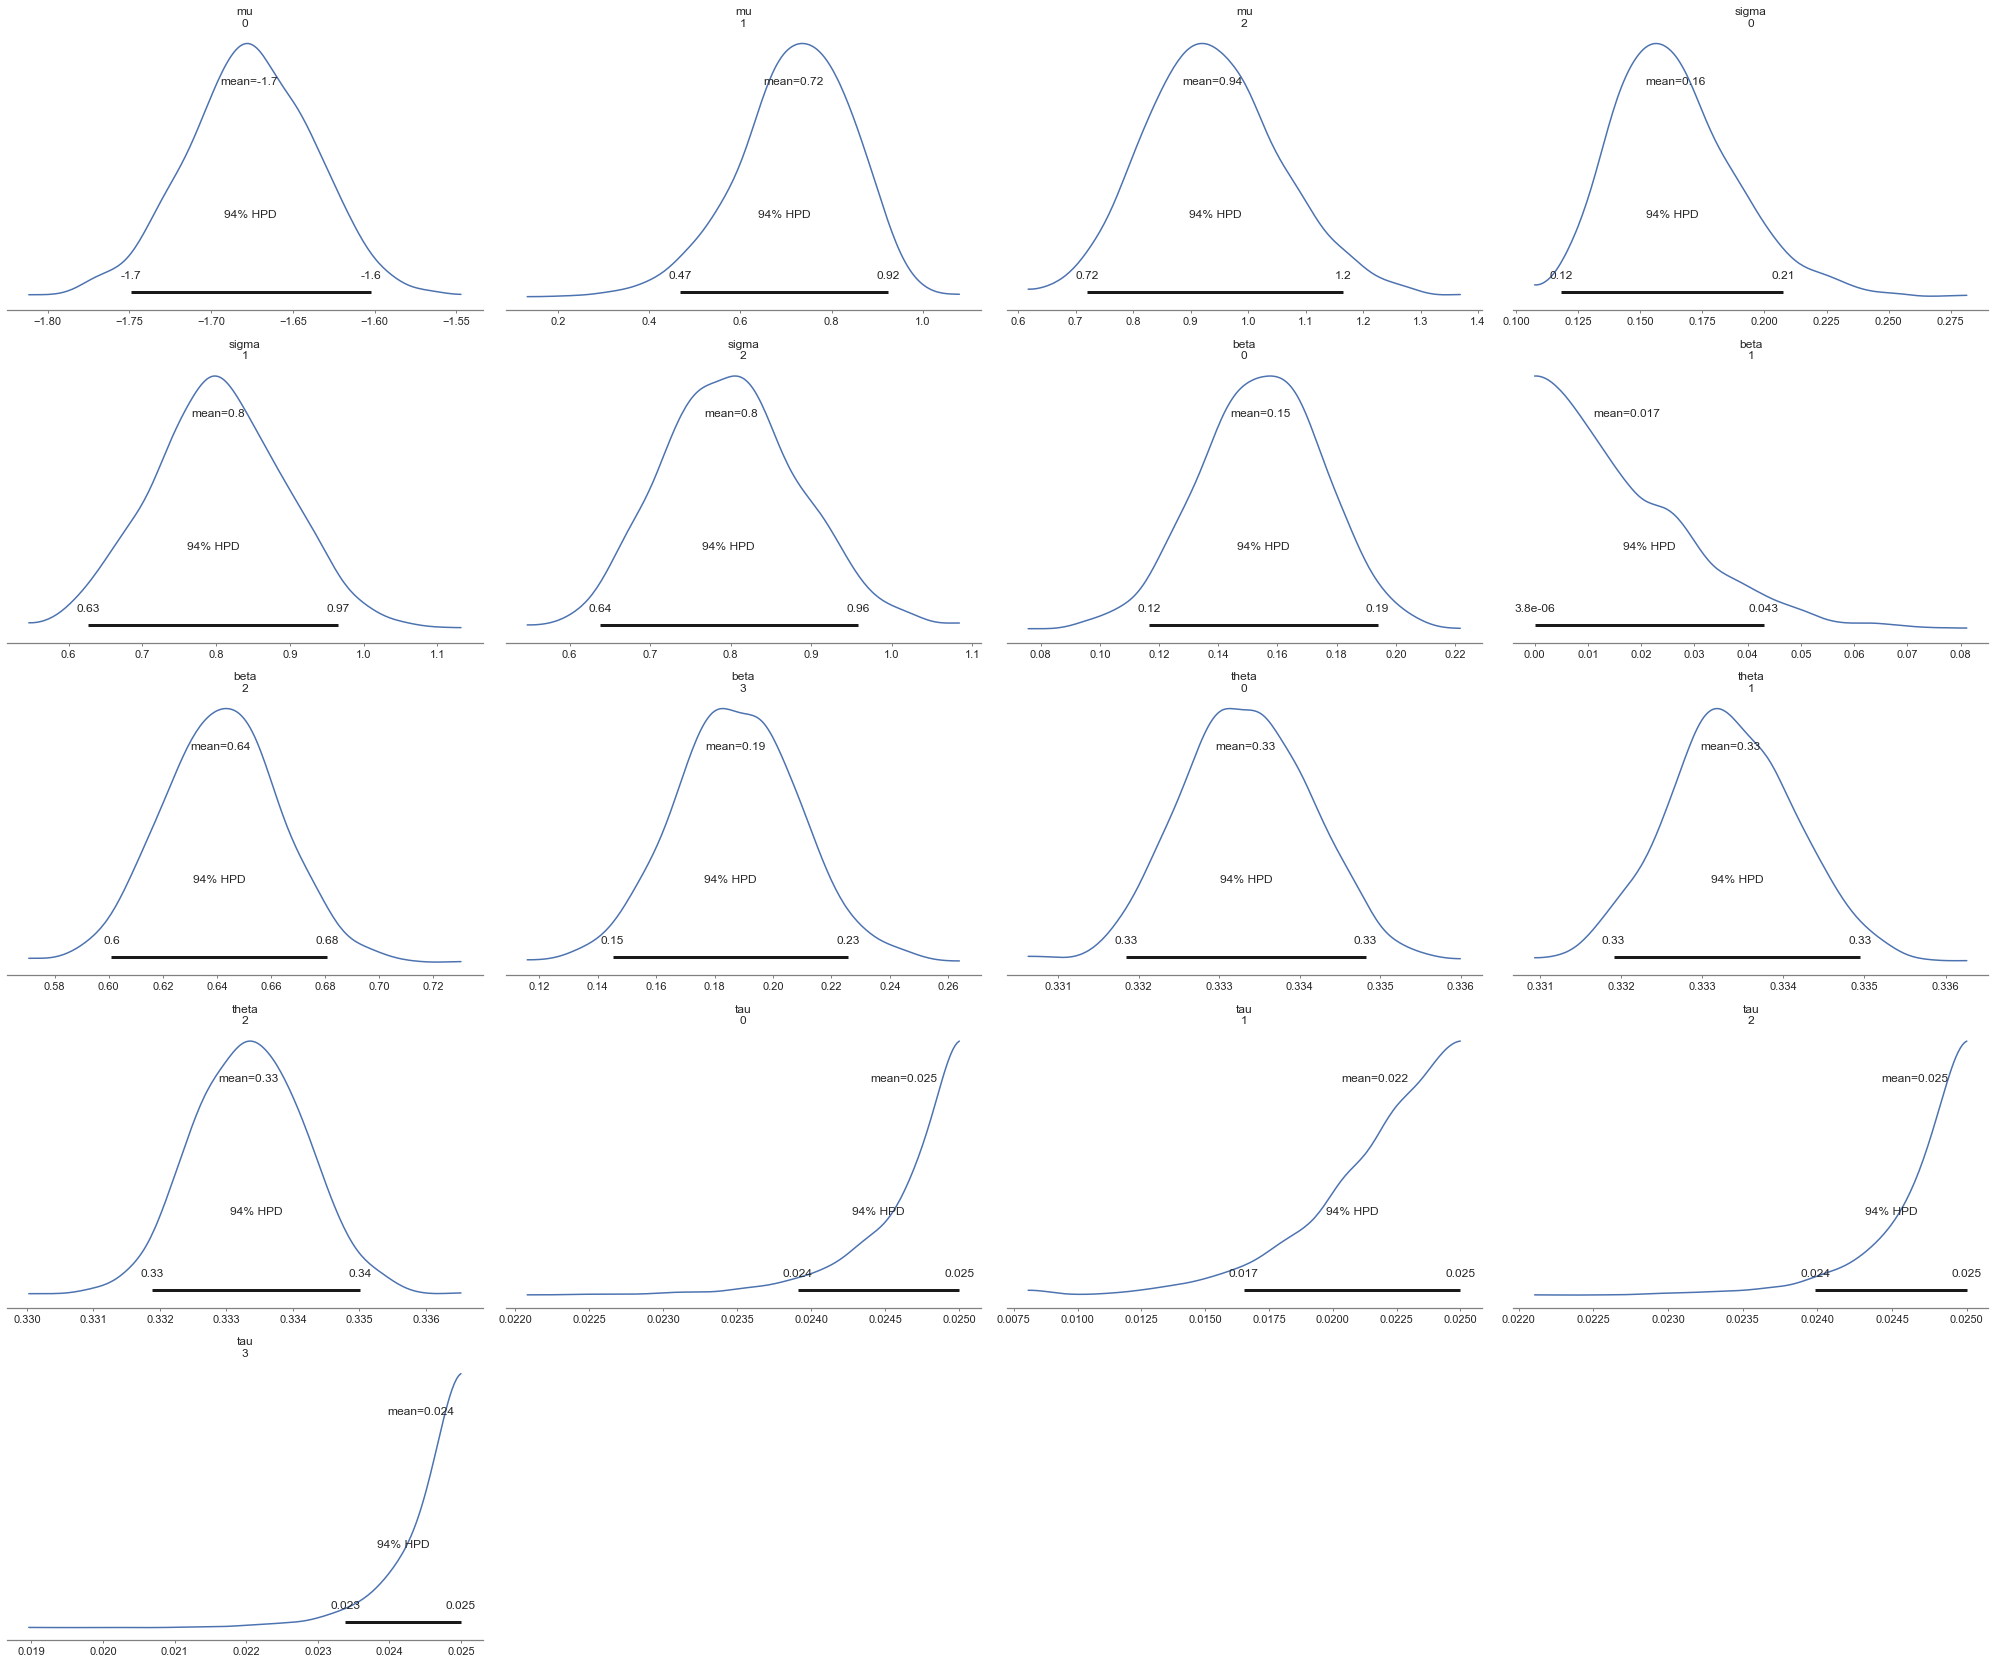

In [98]:
fit_data = az.from_pystan(
    posterior=fit_expanded,
    posterior_predictive=["y_pred","y_1d"],
    observed_data=["y"],
    log_likelihood={"y": "log_lik"},
    coords={"species": species, "features": features},
    dims={
        "mu": ["species"],
        "sigma": ["species"],
        "tau": ["features"],
        "beta": ["features"],
        "theta": ["species"]
    },
)

_ = az.plot_posterior(fit_expanded, ['mu', 'sigma','beta','theta','tau'])

In [100]:
max_test, min_test, mean_test, std_test, med_test = ([] for i in range(5))
max_test_rl, min_test_rl, mean_test_rl, std_test_rl, med_test_rl = ([] for i in range(5))
for unique_value, grouped_array in fit_data.posterior_predictive.sel(chain=0).groupby('draw'):
    ypred = grouped_array.y_pred.values
    y_1d = grouped_array.y_1d.values
    max_test_rl.append(np.max(y_1d))
    min_test_rl.append(np.min(y_1d))
    mean_test_rl.append(np.mean(y_1d))
    std_test_rl.append(np.std(y_1d))
    med_test_rl.append(np.median(y_1d))
    max_test.append(np.max(ypred))
    min_test.append(np.min(ypred))
    mean_test.append(np.mean(ypred))
    std_test.append(np.std(ypred))
    med_test.append(np.median(ypred))

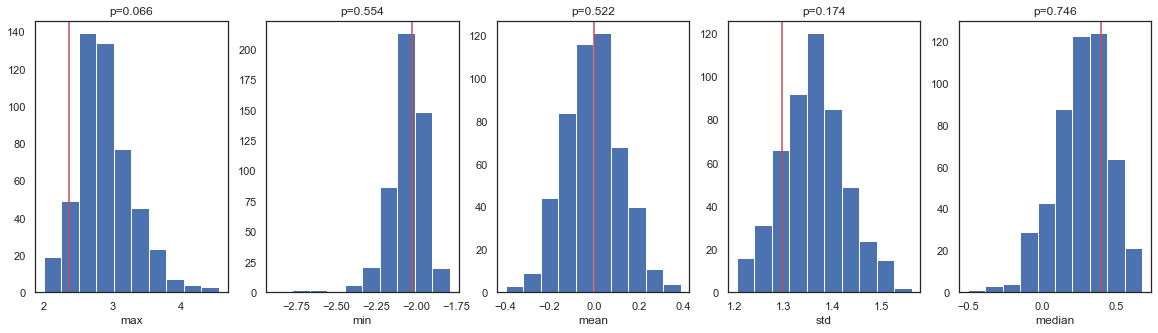

In [101]:
fig, axs = plt.subplots(1, 5, figsize=(20,5))
axs[0].hist(max_test)
axs[0].axvline(np.mean(max_test_rl), color='r')
axs[0].set_xlabel('max')
axs[0].set_title('p=' + str(calc_p(max_test, np.mean(max_test_rl))))
axs[1].hist(min_test)
axs[1].axvline(np.mean(min_test_rl), color='r')
axs[1].set_xlabel('min')
axs[1].set_title('p=' + str(calc_p(min_test, np.mean(min_test_rl))))
axs[2].hist(mean_test)
axs[2].axvline(np.mean(mean_test_rl), color='r')
axs[2].set_xlabel('mean')
axs[2].set_title('p=' + str(calc_p(mean_test, np.mean(mean_test_rl))))
axs[3].hist(std_test)
axs[3].axvline(np.mean(std_test_rl), color='r')
axs[3].set_xlabel('std')
axs[3].set_title('p=' + str(calc_p(std_test, np.mean(std_test_rl))))
axs[4].hist(med_test)
axs[4].axvline(np.mean(med_test_rl), color='r')
axs[4].set_xlabel('median')
_ = axs[4].set_title('p=' + str(calc_p(med_test, np.mean(med_test_rl))))

#### Graphical posterior predictive check

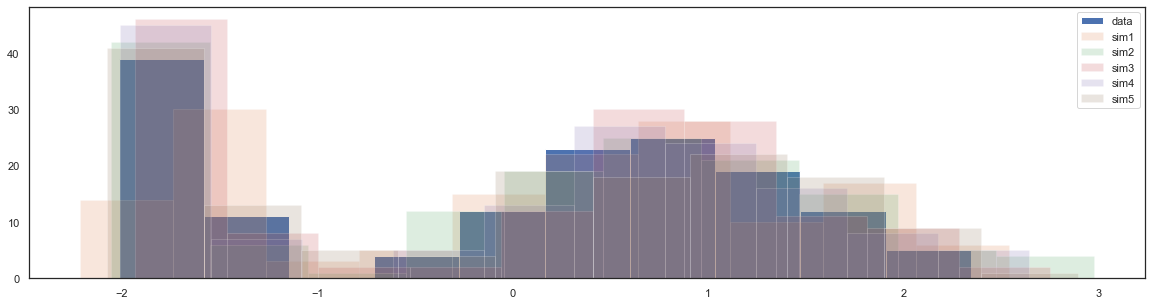

In [102]:
fig, axs = plt.subplots(1, 1, figsize=(20,5))
scaled_1d_data = X_scaled.values @ fit_expanded.extract()['beta'].mean(axis=0)
axs.hist(scaled_1d_data, label='data')
fit_values = fit_data.posterior_predictive.sel(chain=0).y_pred.values
for i in range(5):
    axs.hist(fit_values[i], label='sim' + str(i+1), alpha=0.2)

axs.legend()
    
plt.show()

In [103]:
fitted_mu = fit_expanded.extract()['mu'].mean(axis=0)
fitted_sigma = fit_expanded.extract()['sigma'].mean(axis=0)
N = iris_dat['N']
J = iris_dat['J']
correct = 0
for i in range(N):
    p = [0] * J
    for j in range(J):
        p[j] = stats.norm.pdf(scaled_1d_data[i], fitted_mu[j], fitted_sigma[j])
    correct += np.argmax(p) == target[i]

print('Guessing score: ' + str(round(correct/N * 100,2)) + '%')

Guessing score: 94.67%


### WAIC Evaluation

In [105]:
def waic(fit):
    log_lik = fit.extract()['log_lik']
    lppd = np.log(np.exp(log_lik).mean(axis=0)).sum()
    p_waic = np.var(log_lik, axis=0).sum()
    waic = -2*lppd + 2*p_waic
    return round(waic, 3)


In [106]:
print('First model Waic = {}'.format(waic(fit_first)))
print('Expanded model Waic = {}'.format(waic(fit_expanded)))

First model Waic = 343.648
Expanded model Waic = 343.828


The Expanded model improved our guessing score but it has worse p-values in max, std and median. In addition its Waic is worse than the first model.